### Ej 4:
Programar una red neuronal con arquitectura Unet que incluya el
tiempo embebido como entrada adicional. Definir una clase TimeEmbedding(
nn.Module).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

class TimeEmbedding(nn.Module):
    """
    Genera el Time Embedding Posicional Sinusoidal.

    Argumentos:
        dim (int): La dimensión de salida del embedding
    """
    def __init__(self,dim:int):
        super().__init__()
        self.dim=dim
        self.half_dim=dim//2

        embeddings = np.log(10000)/(self.half_dim-1)
        embeddings = torch.exp(torch.arange(self.half_dim)*-embeddings)

        # Guardar las frecuencias como un buffer (no es un parámetro aprendible)
        self.register_buffer('embeddings',embeddings)

        # MLP para proyector el embedding sinusoidal a un embedding util
        self.mlp = nn.Sequential(
            nn.Linear(dim,dim*4),
            nn.GELU(),
            nn.Linear(dim*4,dim)
        )
    
    def forward(self,time:torch.Tensor):
        """
        time: Tensor (batch,)
        return: Tensor (batch, dim)
        """
        time_tensor=time.unsqueeze(-1)  # (B,1)
        scaled_time=time_tensor*self.embeddings.unsqueeze(0)    # (B,half_dim)

        embeddings=torch.cat(
            [torch.sin(scaled_time),torch.cos(scaled_time)],dim=-1) # (B,dim)

        embeddings=self.mlp(embeddings)

        return embeddings

# B: Batch size (ej. 4)
# D: Dimensión de salida (ej. 128)
# time_steps: Los pasos de difusión (t=50, t=10, t=180, t=1).
time_steps = torch.tensor([50, 10, 180, 1]) 
embedding_dim = 10

# Inicializar y ejecutar
time_embedder = TimeEmbedding(dim=embedding_dim)
embedded_t = time_embedder(time_steps)

print(f"Input time steps: {time_steps}")
print(f"Output embedding shape: {embedded_t.shape}") 
print(embedded_t.T)

Input time steps: tensor([ 50,  10, 180,   1])
Output embedding shape: torch.Size([4, 10])
tensor([[ 0.0055, -0.0405,  0.0769, -0.0878],
        [-0.1484,  0.2284,  0.1896, -0.0407],
        [ 0.0034, -0.2316, -0.1732,  0.1689],
        [ 0.0960, -0.1811, -0.1621,  0.1097],
        [-0.1316, -0.3750, -0.3575, -0.2198],
        [-0.1071, -0.0013,  0.0627, -0.1790],
        [-0.0666,  0.0729, -0.0716,  0.0536],
        [-0.0099,  0.2539,  0.1964,  0.0795],
        [-0.2556, -0.4735, -0.3319, -0.2225],
        [-0.1998, -0.2207, -0.1410, -0.2265]], grad_fn=<PermuteBackward0>)


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_c, out_c, time_emb_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, 3, padding=1)
        self.conv2 = nn.Conv2d(out_c, out_c, 3, padding=1)
        self.act = nn.SiLU()

        # proyección del embedding de tiempo → canales
        self.time_mlp = nn.Linear(time_emb_dim, out_c)

        # atajo si cambia el número de canales
        self.shortcut = nn.Conv2d(in_c, out_c, 1) if in_c != out_c else nn.Identity()

    def forward(self, x, t_emb):
        h = self.act(self.conv1(x))

        # expandir el embedding para sumarlo
        time_term = self.time_mlp(t_emb)[:, :, None, None]
        h = h + time_term

        h = self.act(self.conv2(h))

        return h + self.shortcut(x)
    

In [3]:
class UNetTime(nn.Module):
    def __init__(self, 
                 in_channels=1, 
                 base_channels=64, 
                 time_emb_dim=256):
        super().__init__()

        # --- time embedding ---
        self.time_emb = TimeEmbedding(time_emb_dim)

        # --- encoder ---
        self.down1 = ResidualBlock(in_channels, base_channels, time_emb_dim)
        self.down2 = ResidualBlock(base_channels, base_channels*2, time_emb_dim)
        self.pool = nn.MaxPool2d(2)

        # --- bottleneck ---
        self.bottleneck = ResidualBlock(base_channels*2, base_channels*4, time_emb_dim)

        # --- decoder ---
        self.up1 = nn.ConvTranspose2d(base_channels*4, base_channels*2, 2, stride=2)
        self.dec1 = ResidualBlock(base_channels*4, base_channels*2, time_emb_dim)

        self.up2 = nn.ConvTranspose2d(base_channels*2, base_channels, 2, stride=2)
        self.dec2 = ResidualBlock(base_channels*2, base_channels, time_emb_dim)

        # --- salida ---
        self.final = nn.Conv2d(base_channels, in_channels, 1)

    def forward(self, x, t):
        t_emb = self.time_emb(t)   # (B, time_emb_dim)

        # Encoder
        d1 = self.down1(x, t_emb)
        d2 = self.down2(self.pool(d1), t_emb)

        # Bottleneck
        b = self.bottleneck(self.pool(d2), t_emb)

        # Decoder
        u1 = self.up1(b)
        u1 = torch.cat([u1, d2], dim=1)
        u1 = self.dec1(u1, t_emb)

        u2 = self.up2(u1)
        u2 = torch.cat([u2, d1], dim=1)
        u2 = self.dec2(u2, t_emb)

        return self.final(u2)


### Ej 5:
Escribir una funcion de perdida muestreando el intervalo de tiempos
[0, T] de manera uniforme y definiendo

L = ||ϵ − ϵθ(xt(x0, ϵ), t)||^2 

donde ϵ es una variable gaussiana con media 0 y varianza 1 y xt(x0, ϵ)
esta generado por el proceso directo.

In [4]:
def get_beta_schedule(T, start=1e-4, end=0.02):
    return torch.linspace(start, end, T)

device = "cuda" if torch.cuda.is_available() else "cpu"

T = 200  # número total de pasos del proceso de difusión

beta = get_beta_schedule(T)
alpha = 1 - beta
alpha_cumprod = torch.cumprod(alpha, dim=0).to(device)  # ᾱ_t

def q_sample(x0, eps, t, alpha_cumprod):
    """
    Genera x_t = sqrt(ᾱ_t) x0 + sqrt(1 - ᾱ_t) ε
    x0: (B, C, H, W)
    eps: (B, C, H, W)
    t: (B,) cada t es un entero en [0, T-1]
    """
    # seleccionar ᾱ_t para cada elemento del batch
    a_t = alpha_cumprod[t].reshape(-1, 1, 1, 1)  # (B,1,1,1)

    return torch.sqrt(a_t) * x0 + torch.sqrt(1 - a_t) * eps

In [5]:
def diffusion_loss(model, x0, alpha_cumprod):
    """
    model: UNetTime
    x0: batch de imagenes reales
    """

    B = x0.shape[0]

    # muestreo de tiempos uniformes en [0, T)
    t = torch.randint(0, len(alpha_cumprod), (B,), device=x0.device)

    # muestreo de ruido gaussiano
    eps = torch.randn_like(x0)

    # generar x_t(x0, eps)
    xt = q_sample(x0, eps, t, alpha_cumprod)

    # predecir ε_θ(xt, t)
    eps_pred = model(xt, t)

    # pérdida L2
    loss = torch.mean((eps - eps_pred) ** 2)

    return loss

### Ej 6:

Entrenar la red usando los datos de mnist y evaluar su performance en
terminos de la capacidad de eliminar el ruido de una muestra que paso
por el proceso directo.

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: x * 2 - 1   # escalar a [-1, 1]
])

mnist_train = datasets.MNIST(root="./data", train=True, transform=transform, download=True)

dataloader = DataLoader(mnist_train, batch_size=128, shuffle=True)


In [7]:
model = UNetTime(in_channels=1, base_channels=64, time_emb_dim=256).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [8]:
num_epochs = 200
loss_history = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for x0, _ in dataloader:
        x0 = x0.to(device)

        loss = diffusion_loss(model, x0, alpha_cumprod)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(dataloader)
    loss_history.append(epoch_loss)

    print(f"Epoch {epoch+1}/{num_epochs} — Loss: {loss.item():.4f}")


Epoch 1/200 — Loss: 0.0993
Epoch 2/200 — Loss: 0.0794
Epoch 3/200 — Loss: 0.0894
Epoch 4/200 — Loss: 0.0843
Epoch 5/200 — Loss: 0.0741
Epoch 6/200 — Loss: 0.0692
Epoch 7/200 — Loss: 0.0556
Epoch 8/200 — Loss: 0.0604
Epoch 9/200 — Loss: 0.0583
Epoch 10/200 — Loss: 0.0611
Epoch 11/200 — Loss: 0.0520
Epoch 12/200 — Loss: 0.0494
Epoch 13/200 — Loss: 0.0740
Epoch 14/200 — Loss: 0.0508
Epoch 15/200 — Loss: 0.0561
Epoch 16/200 — Loss: 0.0596
Epoch 17/200 — Loss: 0.0513
Epoch 18/200 — Loss: 0.0511
Epoch 19/200 — Loss: 0.0502
Epoch 20/200 — Loss: 0.0530
Epoch 21/200 — Loss: 0.0545
Epoch 22/200 — Loss: 0.0509
Epoch 23/200 — Loss: 0.0581
Epoch 24/200 — Loss: 0.0527
Epoch 25/200 — Loss: 0.0444
Epoch 26/200 — Loss: 0.0540
Epoch 27/200 — Loss: 0.0519
Epoch 28/200 — Loss: 0.0614
Epoch 29/200 — Loss: 0.0474
Epoch 30/200 — Loss: 0.0524
Epoch 31/200 — Loss: 0.0471
Epoch 32/200 — Loss: 0.0465
Epoch 33/200 — Loss: 0.0529
Epoch 34/200 — Loss: 0.0490
Epoch 35/200 — Loss: 0.0468
Epoch 36/200 — Loss: 0.0462
E

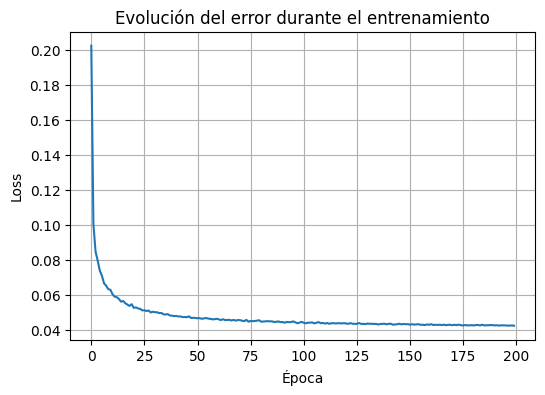

In [9]:
plt.figure(figsize=(6,4))
plt.plot(loss_history)
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Evolución del error durante el entrenamiento")
plt.grid(True)
plt.show()


In [10]:
def denoise_once(model, x0, t, alpha_cumprod):
    """
    Aplica el proceso directo de ruido y luego lo invierte en un solo paso.
    Esto NO es sampling completo DDPM, sino evaluación para medir rendimiento.
    """
    model.eval()
    with torch.no_grad():
        eps = torch.randn_like(x0)
        xt = q_sample(x0, eps, torch.tensor([t]*x0.size(0), device=x0.device), alpha_cumprod)

        eps_pred = model(xt, torch.tensor([t]*x0.size(0), device=x0.device))

        at = alpha_cumprod[t]
        bt = beta[t]

        x0_rec = (xt - eps_pred*torch.sqrt(1 - at)) / torch.sqrt(at)
    
    return xt, x0_rec

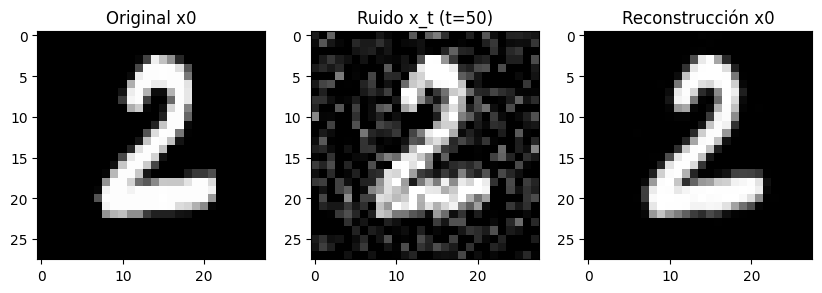

In [34]:
import matplotlib.pyplot as plt

# tomar una imagen del dataset
x0, _ = next(iter(dataloader))
x0 = x0[:1].to(device)  # una sola

t = 50  # ruido medio (0=sin ruido, 199=ruido total)

xt, x0_rec = denoise_once(model, x0, t, alpha_cumprod)

# convertir a [0,1] para mostrar
to_img = lambda x: (x.clamp(-1,1) + 1) / 2

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.title("Original x0")
plt.imshow(to_img(x0[0]).cpu().squeeze(), cmap='gray')

plt.subplot(1,3,2)
plt.title(f"Ruido x_t (t={t})")
plt.imshow(to_img(xt[0]).cpu().squeeze(), cmap='gray')

plt.subplot(1,3,3)
plt.title("Reconstrucción x0")
plt.imshow(to_img(x0_rec[0]).cpu().squeeze(), cmap='gray')

plt.show()


### Como generar digitos MNIST nuevos desde ruido?

Dado que aprendimos el error ϵ≈ϵθ(xt(x0, ϵ), t), podemos usar la estimacion de x_(t-1) (media proceso inverso) para generar nuevos digitos:

x_(t-1) = µθ(x_t,t)+σ_t * ruido

1/sqrt(alfa_t)(x_t-beta_t ϵθ(x_t,t)/sqrt(1-alfa_cumprod_t))+sqrt(beta_t) * ruido

In [13]:
@torch.no_grad()
def sample(model, alpha, alpha_cumprod, img_size=28, device="cuda"):
    model.eval()

    T = len(alpha)

    # empezar desde ruido puro
    x = torch.randn(1, 1, img_size, img_size, device=device)
    x_vec =[x]
    for t in reversed(range(T)):
        t_tensor = torch.tensor([t], device=device)

        beta_t = 1 - alpha[t]
        alpha_cum_t = alpha_cumprod[t]

        # predecir ruido
        eps_pred = model(x, t_tensor)

        # calculo media
        x = (1/torch.sqrt(alpha[t]))*(
            x - (beta_t / torch.sqrt(1 - alpha_cum_t))*eps_pred)

        # agregar ruido aleatorio excepto en t=0
        if t > 0:
            noise = torch.randn_like(x)
            x = x + torch.sqrt(beta_t)*noise
        x_vec.append(x)

    return x_vec


In [14]:
sampled_vec = sample(model, alpha, alpha_cumprod, device=device)
print(len(sampled_vec),len(sampled_vec[0]),len(sampled_vec[0][0]),len(sampled_vec[0][0][0]),len(sampled_vec[0][0][0][0]))

201 1 1 28 28


In [15]:
def plot_sampling_progress(x_vec, n_steps=6):
    """
    x_vec: lista de tensores [x_T, x_{T-1}, ..., x_0]
    n_steps: cuántas imágenes intermedias mostrar (incluye inicio y fin)
    """

    total_steps = len(x_vec)

    # indices equiespaciados
    idx = torch.linspace(0, total_steps-1, n_steps).long().tolist()

    # convertir a imágenes [0,1]
    to_img = lambda x: (x.clamp(-1,1) + 1) / 2

    plt.figure(figsize=(3*n_steps, 3))

    for i, step in enumerate(idx):
        img = to_img(x_vec[step][0]).cpu().squeeze()

        if step == 0:
            title = f"Ruido inicial\n(t={total_steps-1})"
        elif step == total_steps-1:
            title = f"Resultado final\n(t=0)"
        else:
            title = f"t={total_steps-1 - step}"

        plt.subplot(1, n_steps, i+1)
        plt.imshow(img, cmap="gray")
        plt.title(title)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


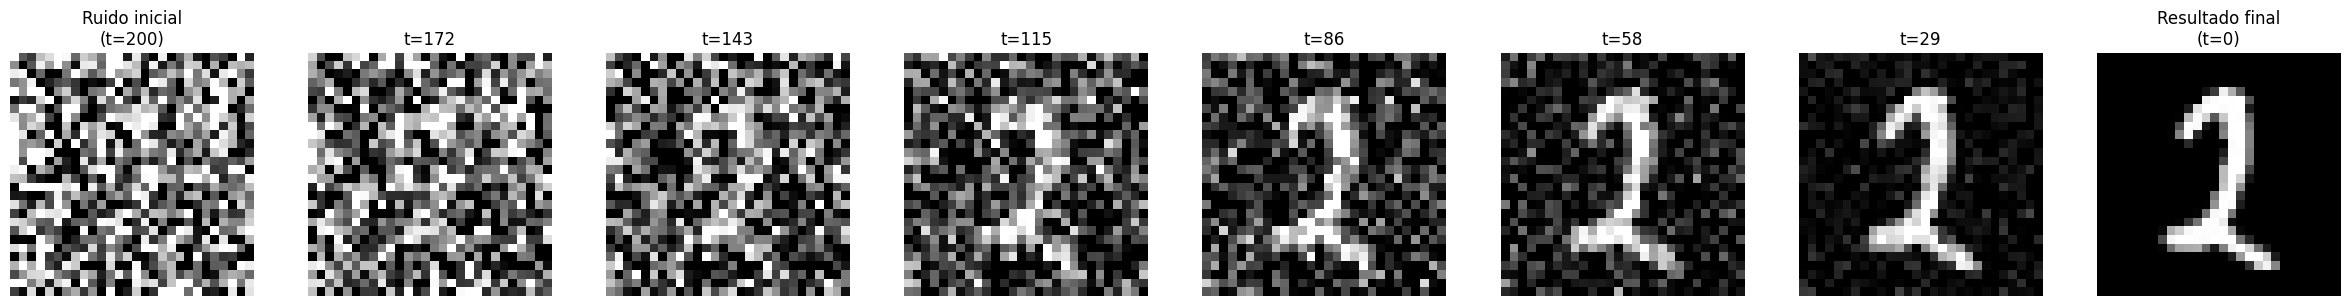

In [47]:
sampled_vec = sample(model, alpha, alpha_cumprod, device=device)
plot_sampling_progress(sampled_vec, n_steps=8)